# Simulation

We will discuss how to structure and implement simulation frameworks.

Reading: none

## Simulation Loop

Simulations require repeating the following procedure for each agent, for each timestep:
1. Actions have taken you to a new location
2. Make observations
3. Update your belief
4. Assess your next action
5. Act

![Simulation Loop](figures/sim_circle.png)

For games with perfect information you don't even need to make observations:
1. Assess your next action
2. Act

This extends to physics simulations as well. Here, assessing your next action simply means following the laws of physics.

## Bouncing Ball

With the simplest systems we can derive the motion analytically.

$$y = 1-|sin(t)|$$

INFO: Recompiling stale cache file /home/tim/.julia/lib/v0.4/Compose.ji for module Compose.
ErrorException("The dynamically loaded GMP library (version 6.1.0 with __gmp_bits_per_limb == 64)
does not correspond to the compile time version (version 5.1.3 with __gmp_bits_per_limb == 64).
Please rebuild Julia.")


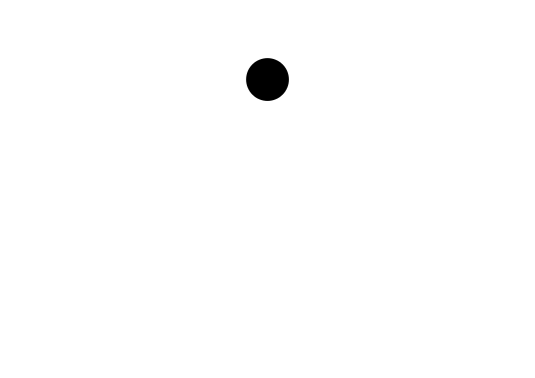

In [1]:
using Reactive, Interact, Compose

function drawball(t)
    y = 1-abs(sin(t)) # The y coordinate.
    compose(context(), circle(0.5, y, 0.04))
end

map(drawball, map(_ -> time(), fps(60)))

## N-Body Problem

The $n$-body problem refers to simulating orbiting bodies. With $n > 2$ there is no analytical solution.

Let us set up an $n$-body simulator.

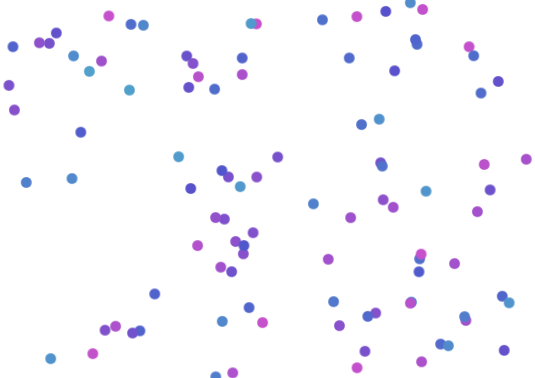

In [16]:
using Reactive, Interact, Compose, Colors

immutable Pt
    x::Float64 # x-position
    y::Float64 # y-position
    u::Float64 # x-velocity
    v::Float64 # y-velocity
    color::Colorant
end
type State
    pts::Vector{Pt}
end
function render(pt::Pt)
   compose(context(), circle(pt.x, pt.y, 0.01), fill(pt.color))  
end
function render(s::State)
    compose(context(), map(render, s.pts)) 
end

srand(0)
s = State(map(i->Pt(rand(), rand(), randn(), randn(), HSV(200 + 100*rand(), 0.6, 0.8)), 1:100))
render(s)

Each agent acts according to the law of gravitation:

$$F_{i} = \sum_{j=1}^N G \frac{m_i m_j}{r_{j\rightarrow i}^2} \hat{r}_{j\rightarrow i}$$

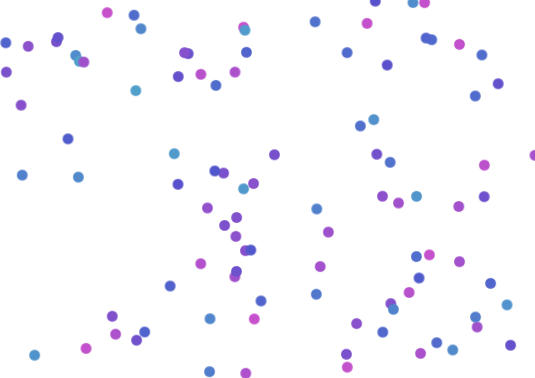

In [3]:
function act!(i::Int, s::State, Δt::Float64)
    force = [0.0,0.0]
    I = s.pts[i]
    for (j,J) in enumerate(s.pts)
        if j != i
            u = [J.x - I.x, J.y - I.y]
            r = norm(u)
            u ./= r
            force += u ./ r^2
            force -= 0.1*u ./ r^3 # let's also include a `strong` force
        end
    end
    force .*= 0.01 # account for G and masses
    force = clamp(force, -5.0, 5.0) # clamp to prevent explosions
    
    # adjust velocity according to force
    s.pts[i] = Pt(I.x, I.y, I.u + force[1]*Δt, I.v + force[2]*Δt, I.color)
end
function propagate!(i::Int, s::State, Δt::Float64;
    friction::Float64=0.99, rebound::Float64=0.9)
    
    # update position based on velocity
    I = s.pts[i]
    x = I.x+I.u*Δt
    y = I.y+I.v*Δt
    u = I.u*friction
    v = I.v*friction
    
    # let's stay inside the box
    if x > 1.0
        x = 1.0
        u = -u*rebound # lose energy on bounce and flip direction
    elseif x < 0.0
        x = 0.0
        u = -u*rebound
    end
    
    if y > 1.0
        y = 1.0
        v = -v*rebound # lose energy on bounce and flip direction
    elseif y < 0.0
        y = 0.0
        v = -v*rebound
    end
    
    s.pts[i] = Pt(x, y, u, v, I.color)
    s
end
function tick!(t, Δt=1/60)
    for i in 1 : length(s.pts)
        act!(i, s, Δt) 
    end
    for i in 1 : length(s.pts)
        propagate!(i, s, Δt)
    end
    render(s)
end

map(tick!, map(_ -> time(), fps(60)))

## Sampling

Many simulations require random numbers, whether for random initialization, sampling from stochastic models, for for other purposes.

In [1]:
rand() # random number from 0 to 1

0.07226489860653196

In [2]:
rand(5) # 5 samples from rand

5-element Array{Float64,1}:
 0.0473091
 0.373446 
 0.882296 
 0.382655 
 0.593841 

In [3]:
randn() # normally distributed number (Gaussian with mean 0 and stdev 1)

-0.44095530054655646

In [4]:
2 + 3*randn() # mean 2, stdev 3

0.027992207287421245

The Distributions package provides a large number of Distributions for your use. We have already seen many of them.
You can sample from them with `rand`.

In [5]:
using Distributions
N = Normal(2, 3) # mean 2, stdev 3
rand(N)

5.918617281779508

In [6]:
rand(N, 5) # five samples from N

5-element Array{Float64,1}:
  5.69444
  1.30567
 -1.34311
 -2.46045
  6.04644

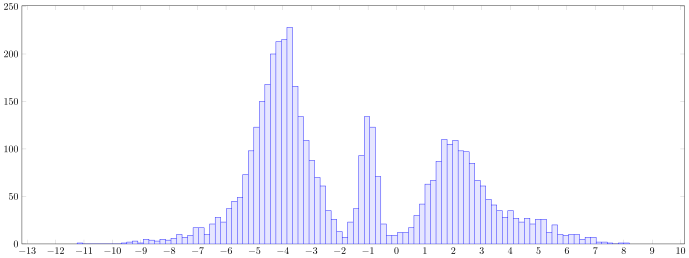

In [7]:
using PGFPlots
srand(0)
data = [randn(500).*1.8 .+ -5;
        randn(2000).*0.8 .+ -4;
        randn(500).*0.3 .+ -1;
        randn(1000).*0.8 .+ 2;
        randn(500).*1.5 .+ 4;
       ]
data = filter!(x->-15.0 <= x <= 15.0, data)
Axis(Plots.Histogram(data, bins=100), ymin=0, width="25cm", height="10cm")

In [9]:
using BayesNets
bn = BayesNet()
push!(bn, StaticCPD(:a, Normal(1.0))) # N(0,1)
push!(bn, LinearGaussianCPD(:b, [:a], [2.0], 3.0, 1.0)) # N(2a + 3, 1)

In [10]:
rand(bn)

Dict{Symbol,Any} with 2 entries:
  :a => 0.8985789118304577
  :b => 5.7892086573646715

In [11]:
rand(bn, 5)

,a,b
1,-0.2038582877753905,2.816026094388472
2,0.7134405868684338,5.193556588008004
3,0.8122384837052554,4.322310408698054
4,-0.5069135255215831,1.0288970414572138
5,1.3661765665975691,6.148822051738227


## Simulation with Stochasticity

There are three common places where you will need stochasticity:
1. randomly initializing the start state
2. randomness in the transition (motion noise)
3. randomness in the observation (sensor noise)

For the class you will be asked to implement all three of these.
This week you only need to implement the first two - `sample_initial` and `sample_transition`.

# Assignment 5

Your task is to Write code for sampling from your encounter model and running a simulation that captures the physical dynamics of the aircraft.
You will then leverage your code to run a Monte Carlo analysis on the safety of aircraft.

A class competition will take place to see whose model best represents aircraft encounters.
We will measure how close the histogram over encounter miss distances both with and without TCAS is to the true distribution, and how close the estimated NMAC rate is to the true value.

* distance in each case will be measures using the Kullbeck-Leibler divergence
* TCAS and non-TCAS are evenly weighted
* distance from collision rate is measured by the factor difference magnitude - ie, 5 and 20 are both factors of 2 from 10.

### What is Turned In

Write all of your code in a file structured identically to "my_encounter_model.jl" and turn it in to Coursework.

In [1]:
using AA120Q

In [2]:
srand(0) # set random seed for consistent results
using BayesNets
import JLD

## EncounterModel Type

We create our custom encounter model and make sure that it follows the AA120Q Encounter Model API:

In [4]:
type DemoEncounterModel <: EncounterModel
    initial::DiscreteBayesNet
    initdisc::Dict{Symbol,LinearDiscretizer}
    transition::MvNormal
    
    nsteps::Int # number of steps to simulate
    Δt::Float64 # timestep [s]
end

# load the model
jld = JLD.load(Pkg.dir("AA120Q", "data", "myencountermodel.jld"))
model = DemoEncounterModel(jld["initial"], jld["initdisc"], jld["transition"], 50, 1.0);

# Sample from Initial to get Initial Scene

We now have to implement `Base.rand(model)` which should generate Encounters.

Review the definitions from the previous notebook...

`sample_initial` should take in an EncounterModel and produce the airspace class, the aircraft categories, and two AircraftStates

In [5]:
function AA120Q.sample_initial(model::DemoEncounterModel)
    sample = rand(model.initial) # pull sufficient stats for initial scene
    
    # convert discrete samples to continuous samples
    initdisc = model.initdisc
    sample[:h1] = decode(initdisc[:h], sample[:h1])
    sample[:h2] = decode(initdisc[:h], sample[:h2])
    sample[:v1] = decode(initdisc[:v], sample[:v1])
    sample[:v2] = decode(initdisc[:v], sample[:v2])
    sample[:r] = decode(initdisc[:r], sample[:r])
    sample[:α] = decode(initdisc[:α], sample[:α])
    sample[:β] = decode(initdisc[:β], sample[:β])
    
    # initial aircraft positions
    s1 = AircraftState(0.0,0.0,sample[:h1],0.0,sample[:v1],0.0)

    r, α, β = sample[:r], sample[:α], sample[:β]
    x2 = r*cos(α)
    y2 = r*sin(α)
    ψ2 = β

    s2 = AircraftState(x2,y2,sample[:h2],ψ2,sample[:v2],0.0)
    
    (sample[:A], sample[:C1], sample[:C2], s1, s2)
end

sample_initial (generic function with 2 methods)

# Sample Traces

`sample_transition` takes a model and two aircraft states and returns the actions for each aircraft at that timestep.


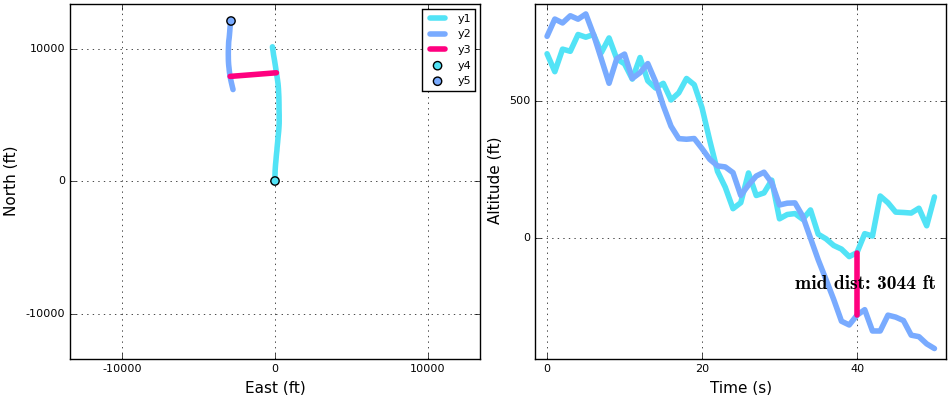

In [7]:
function AA120Q.sample_transition(s1::AircraftState, s2::AircraftState, model::DemoEncounterModel, params::EncounterSimParams)
    
    v = rand(model.transition) # [dv, dh, dψ]
    a1 = AircraftAction(v[1], v[2], v[3])

    v = rand(model.transition) # [dv, dh, dψ]
    a2 = AircraftAction(v[1], v[2], v[3])
    
    (a1, a2)
end

enc = rand(model, DEFAULT_SIM_PARAMS)
plot_encounter(enc)

Interact.Slider{Float64}(Signal{Float64}(25.5, nactions=0),"t",25.5,linspace(0.0,51.0,101),true)

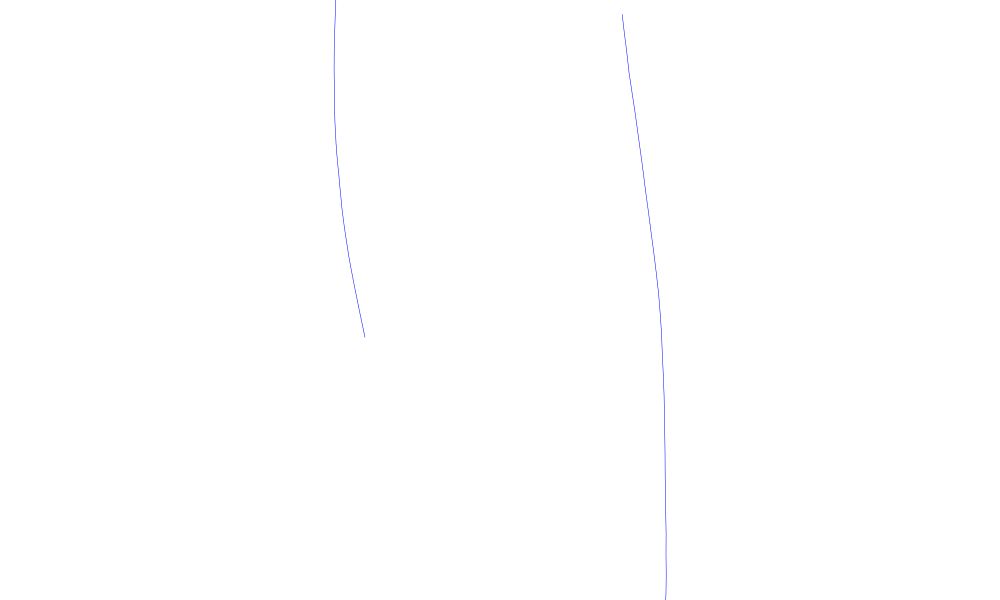

In [8]:
using Interact
@manipulate for t in linspace(0.0, length(enc.trace1)*enc.Δt, 101)
    render(enc, t)
end

# Running with TCAS

We will use a simple TCAS (Traffic Alert and Collision Avoidance System) model. Internationally it is known as ACAS
(Airborne Collision Avoidance System). A Series of midair collisions led to airline and governmental action to
develop airborne devices that function independent of air traffic control (ATC) for alerting and collision avoidance. 

The output of the simple TCAS will be a resolution advisory. The advisory provides the pilot with information in order to fly or avoid to resolve an encounter. The climb rate must be between ±4400 feet per minute.


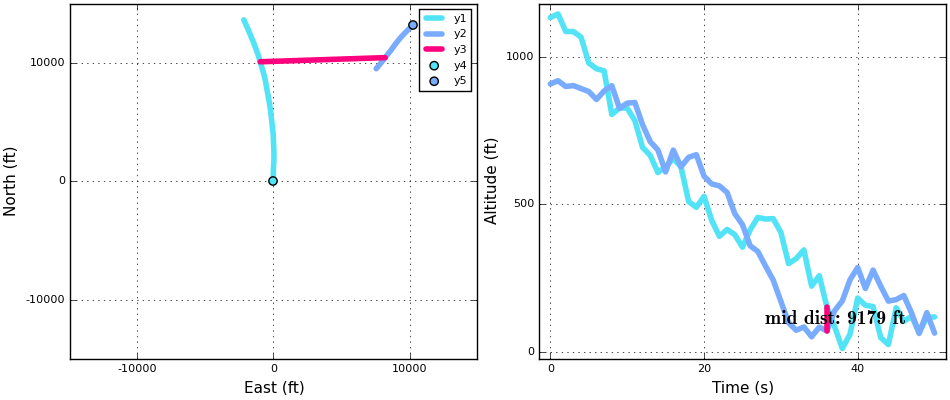

In [9]:
tcas = TCAS()
enc = rand(model, tcas, DEFAULT_SIM_PARAMS)
plot_encounter(enc)

# Generating a Dataset of Encounters

NOTE: students will probably want to generate a set of 1000 or more

In [10]:
encounters_noTCAS = generate_encounters(1000, model, DEFAULT_SIM_PARAMS);

In [11]:
encounters_yesTCAS = generate_encounters(1000, model, tcas, DEFAULT_SIM_PARAMS);

# Pulling Miss Distance from Encounter

In [12]:
miss_distance = get_miss_distance(encounters_noTCAS[1])

454.83503196019745

# Pulling Distribution over Miss Distance from Encounters


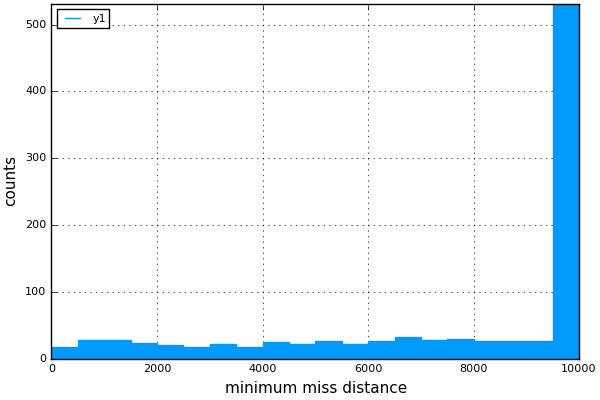

In [13]:
counts_noTCAS = get_miss_distance_counts(encounters_noTCAS)
plot_miss_distance_histogram(counts_noTCAS)

# Safety Analysis

Run a Monte Carlo analysis using your encounter model, to estimate the probability that the encounter leads to a
near-midair collision (NMAC), which is defined as being a loss of 100ft vertical separation, and 500ft horizontal
separation. Estimate the collision frequency $P(col)$ using the NMAC rate obtained from a Monte Carlo estimate.
    
$$P(NMAC\> \mid \> model) = \frac{\text{n collisions}}{\text{n traces}}$$
    
Calculate the Monte Carlo estimate by dividing the number of encounters that lead to an NMAC by the total number of encounters run in simulation. Assume
    
$$P(col \mid NMAC) = 0.1$$

In [14]:

    ################
    # YOUR CODE HERE
    ################


Students will be competing to see who's collision frequency estimate comes closest to the real world value. Winner's prize will be determined at the time of the competition.